# event - display with hits and vertex-hits of my_track objects
from 2TracksClusters file (TwoTracksTree)

In [11]:
import sys; sys.path.insert(0, '../');
from ccqe_notebook_tools import *
from tracking_tools import *
# %matplotlib inline
%matplotlib notebook
from IPython.core.display import HTML,display
display(HTML("<style>.container { width:100% !important; }</style>"))
sys.stdout = open('/dev/stdout', 'w')

In [2]:
#---------------------------------------------------------------------------------------------
def plot_pandoraNuTrack(track,plane,MCmode,ax,label_addition=''):
    color, label = set_color_label(track.MCpdgCode,MCmode=MCmode)
    t_start_wire , t_start_time , t_end_wire , t_end_time = get_t_start_end(track,plane)
    ax.plot( [t_start_wire,t_end_wire] , [t_start_time,t_end_time] ,label=label_addition+' track %d '%track.track_id+label, color=color,alpha=0.5)
    return t_start_wire , t_start_time , t_end_wire , t_end_time , color
#---------------------------------------------------------------------------------------------

#---------------------------------------------------------------------------------------------
def plot_hits(hits,plane,ax=None,box=None,s=50,cmap='hot_r',marker='o',color='',do_add_numbers=False):
    if box is None: box = [ -1 , 10000 , -1 , 10000 ]
    hit_wire, hit_time, hit_charge , hit_number  = [] , [] , [] , []
    # hits in this plane
    for i_hit,hit in enumerate(hits):
        if hit.hit_plane==plane and hit_in_box(hit,box=box):
            hit_number.append(i_hit)
            hit_wire.append(hit.hit_wire)
            hit_time.append(hit.hit_peakT)
            hit_charge.append(hit.hit_charge)
    if ax is not None and hit_wire is not None and hit_time is not None and hit_charge is not None and len(hit_wire)>0:
        if color == '':
            ax.scatter(hit_wire,hit_time,marker=marker,s=s,c=hit_charge, vmin=np.min(hit_charge), vmax=np.max(hit_charge),cmap='hot_r')
        else:
            ax.scatter(hit_wire,hit_time,c=color,marker=marker,s=s)
    if do_add_numbers:
        for w,t,n in zip(hit_wire , hit_time, hit_number): ax.text( w , t , n )

    return hit_wire, hit_time, hit_charge , hit_number
#---------------------------------------------------------------------------------------------


#---------------------------------------------------------------------------------------------
def plot_vertex(all_hits=None , tracks=None, vertex=None , closeup=None,
                planes=[0,1,2], MCmode=True , figsize=(16,6),
                do_add_numbers=False , debug=0 , ax=None , fontsize=20,
                do_possible_hits=False):
    
    fig = plt.figure(figsize=(16,6))
    for plane in planes:        

        non_associated_hits = []
        if debug: print 'plane',plane,'(',vertex.TruthTopologyString,')'
        ax = fig.add_subplot(1,3,plane+1); ax.set_title('%s plane'%('u' if plane==0 else 'v' if plane==1 else 'y'),y=0.95)
        
        roi = vertex.roi_u if plane==0 else vertex.roi_v if plane==1 else vertex.roi_y
        AllHitsInROI = vertex.AllHitsInROI_u if plane==0 else vertex.AllHitsInROI_v if plane==1 else vertex.AllHitsInROI_y
        non_associated_hits = [hit for hit in AllHitsInROI]
        # hits
        hit_wire, hit_time, hit_charge , hit_number = plot_hits(hits=all_hits,plane=plane,ax=ax)


        # pandoraNu tracks
        for track in [vertex.AssignedMuonTrack , vertex.AssignedProtonTrack]:
            t_start_wire , t_start_time , t_end_wire , t_end_time , color = plot_pandoraNuTrack(track=track,plane=plane,MCmode=MCmode,ax=ax)
            # TRACKs boxes
            if debug>1: ax.add_patch( patches.Rectangle( (t_start_wire, t_start_time),                    
                                                        (t_end_wire-t_start_wire) , (t_end_time-t_start_time) ,                                             
                                                        color=color , alpha=0.6,fill=False) )
            
            
        for track in tracks:
            if track.track_id != vertex.AssignedMuonTrack.track_id and track.track_id !=  vertex.AssignedProtonTrack.track_id:
                plot_pandoraNuTrack(track=track,plane=plane,MCmode=MCmode,ax=ax,label_addition='ext.')
            
        my_track_muon = vertex.MyTrackMuon_u if plane==0 else vertex.MyTrackMuon_v if plane==1 else vertex.MyTrackMuon_y
        my_track_proton = vertex.MyTrackProton_u if plane==0 else vertex.MyTrackProton_v if plane==1 else vertex.MyTrackProton_y
    
        # my-tracks
        total_charge_in_my_tracks = 0
        for my_track in [my_track_muon,my_track_proton]:
            color, label = set_color_label(my_track.pandoraNu_track.MCpdgCode,MCmode=MCmode)
            associated_hits = [hit for hit in my_track.hits]
        
            if debug>1:
                if len(associated_hits)>0: 
                    print 'hits in my-track',my_track.pandoraNu_track.track_id
                    for hit in associated_hits:
                        print [hit.hit_wire, hit.hit_peakT]
                else: print 'no hits in my-track',my_track.pandoraNu_track.track_id

            for hit in associated_hits:
                if hit in non_associated_hits:
                    non_associated_hits.remove(hit)

                if do_possible_hits: plot_hits(hits=my_track.possible_hits,plane=plane,ax=ax,marker='s',s=3,color=color)                
                hit_wire, hit_time, hit_charge , hit_number = plot_hits(hits=my_track.hits,plane=plane
                                                                        ,ax=ax,color=color
                                                                        ,do_add_numbers=do_add_numbers)
            total_charge_in_my_tracks += np.sum(hit_charge)


        # CC1p ROI
        min_wire , max_wire , min_time , max_time = roi.start_wire , roi.end_wire , roi.start_time , roi.end_time
        ax.add_patch( patches.Rectangle( (min_wire , min_time ), 
                                        (max_wire - min_wire) , (max_time - min_time) ,fill=False) )
        # vertex position
        ax.scatter( vertex.vertex_wire[plane], vertex.vertex_time[plane] , c='green', s=100 , alpha=0.3)

        # charge deposition
        print 'plane',plane,',total charge in roi:',vertex.AllChargeInVertexROI[plane],'ADC',',total charge in tracks',total_charge_in_my_tracks,'ADC'
        ratio_charge = vertex.ratio_associated_hit_charge_to_total[plane]
        print ratio_charge,'of the charge is in my tracks'

        ax.set_xlim( min_wire - 10 , max_wire + 10 )
        ax.set_ylim( min_time - 50 , max_time + 50 )
        if closeup is not None:
            ax.set_xlim( closeup[0] , closeup[2] )
            ax.set_ylim( closeup[1] , closeup[3] )            
        ax.xaxis.set_major_locator(LinearLocator(4));ax.yaxis.set_major_locator(LinearLocator(4))
        set_axes(ax,x_label='wire',y_label='peak-time' if plane==0 else '',fontsize=fontsize)
        ax.grid(linestyle='--',alpha=0.5,which='both')
        if plane==0: plt.text( min_wire + 5 , min_time + 5 , "%d/%d/%d"%(vertex.run,vertex.subrun,vertex.event))
        if plane!=0 and debug<2: ax.yaxis.set_major_formatter( NullFormatter() )
        if MCmode and plane==0: ax.legend(loc='best',fontsize=fontsize)
            
        if debug:
            if len(non_associated_hits)>0: 
                print 'non-associated hits in roi'
                for hit in non_associated_hits:
                    print [hit.hit_wire, hit.hit_peakT, hit.hit_charge]
            else:
                print 'all hits in roi are track-associated'
    print 'average ratio of associated hit charge to total:',vertex.average_ratio_associated_hit_charge_to_total
    print 'maximal ratio of associated hit charge to total:',vertex.max_ratio_associated_hit_charge_to_total

    plt.tight_layout()
    print 'closest genie vertex (%.1f cm)'%(vertex.position-vertex.closest_genie_interaction.vertex_position).Mag(),'Np,Nπ,Nn:',vertex.closest_genie_interaction.Np,vertex.closest_genie_interaction.Npi,vertex.closest_genie_interaction.Nn
#---------------------------------------------------------------------------------------------



In [8]:
File = ROOT.TFile("/Users/erezcohen/Desktop/uBoone/AnalysisTreesAna/TracksAnaFiles/Events_MCC7_MC_BNB_2TracksClusters.root")
tree = File.Get("TwoTracksTree")
events = AnalyzeVertex( tree )

<IPython.core.display.Javascript object>


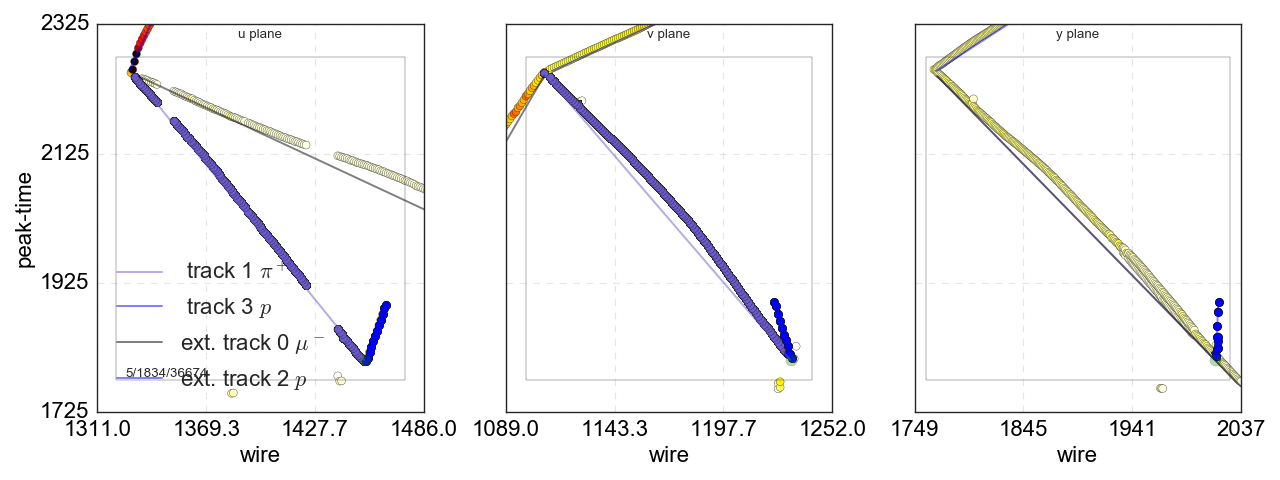

In [10]:
i=12
hits, tracks, TwoTracksClusters = get_CC1p_tracks( events=events, i=i )
if TwoTracksClusters['Nclusters']==0: print 'no vertices in entry',i
for j in range(TwoTracksClusters['Nclusters']):
    vertex = TwoTracksClusters['vertex %d'%j]    
    plot_vertex( all_hits=hits , tracks=tracks , vertex=vertex , debug=1 ,planes=[0,1,2] , figsize=(16,6) , MCmode=True 
                , do_add_numbers=False
                , do_possible_hits=True
#                 , closeup=[712,3300,730,3620]
               )

<IPython.core.display.Javascript object>


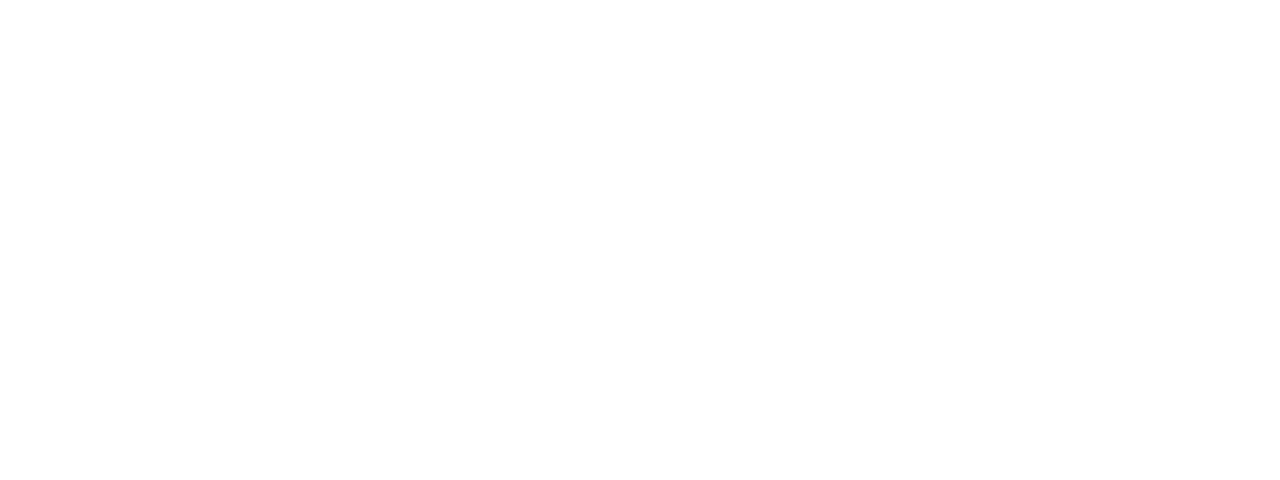

TypeError: plot_vertex() got an unexpected keyword argument 'hits'

In [11]:
i=5
hits, tracks, TwoTracksClusters = get_CC1p_tracks( events=events, i=i )
if TwoTracksClusters['Nclusters']==0: print 'no vertices in entry',i
for i in range(TwoTracksClusters['Nclusters']):
    vertex = TwoTracksClusters['vertex %d'%i]    
    fig = plt.figure(figsize=(16,6))
    for plane in [1]:
        plot_vertex( hits=hits , tracks=tracks , vertex=vertex , debug=4 ,plane=plane , do_add_numbers=False , MCmode=True )        
    plt.tight_layout()